# 15.4 自然语言推断与数据集
- **目录**
  - 15.4.1 自然语言推断
  - 15.4.2 斯坦福自然语言推断（SNLI）数据集
    - 15.4.2.1 读取数据集
    - 15.4.2.2 定义用于加载数据集的类
    - 15.4.2.3 整合代码

- 在 15.1节中，我们讨论了情感分析问题。
- 这个任务的目的是将单个文本序列分类到预定义的类别中，例如一组情感极性中。
- 然而，当需要决定一个句子是否可以从另一个句子**推断**出来，或者需要通过识别语义等价的句子来消除**句子间冗余**时，知道如何对一个文本序列进行**分类是不够**的。
- 相反，我们需要能够对成对的文本序列进行推断。

## 15.4.1 自然语言推断

- **自然语言推断（natural language inference）** 主要研究
**假设（hypothesis）** 是否可以从**前提（premise）** 中推断出来，
其中两者都是文本序列。
- 换言之，自然语言推断决定了一对文本序列之间的逻辑关系。这类关系通常分为三种类型：
  * **蕴涵（entailment）**：假设可以从前提中推断出来。
  * **矛盾（contradiction）**：假设的否定可以从前提中推断出来。
  * **中性（neutral）**：所有其他情况。
- 自然语言推断也被称为识别文本蕴涵任务。
- 例如，下面的一个文本对将被贴上“蕴涵”的标签，因为假设中的“表白”可以从前提中的“拥抱”中推断出来。
  - 前提：两人拥抱在一起。
  - 假设：两人表达爱意。
- 下面是一个“矛盾”的例子，因为“运行编码示例”表示“不睡觉”，而不是“睡觉”。
  - 前提：一名男子正在运行Dive Into Deep Learning的编码示例。
  - 假设：该男子正在睡觉。
- 第三个例子显示了一种“中性”关系，因为“正在为我们表演”这一事实无法推断出“出名”或“不出名”。
  - 前提：音乐家们正在为我们表演。
  - 假设：音乐家很有名。
- 自然语言推断一直是理解自然语言的中心话题。
  - 它有着广泛的应用，从信息检索到开放领域的问答。
  - 为了研究这个问题，我们将首先研究一个流行的自然语言推断基准数据集。

## 15.4.2 斯坦福自然语言推断（SNLI）数据集

- **斯坦福自然语言推断语料库（Stanford Natural Language Inference，SNLI）** 由500000多个带标签的英语句子对组成。
- 后续程序代码在路径`../data/snli_1.0`中下载并存储提取的SNLI数据集。

- SNLI数据集
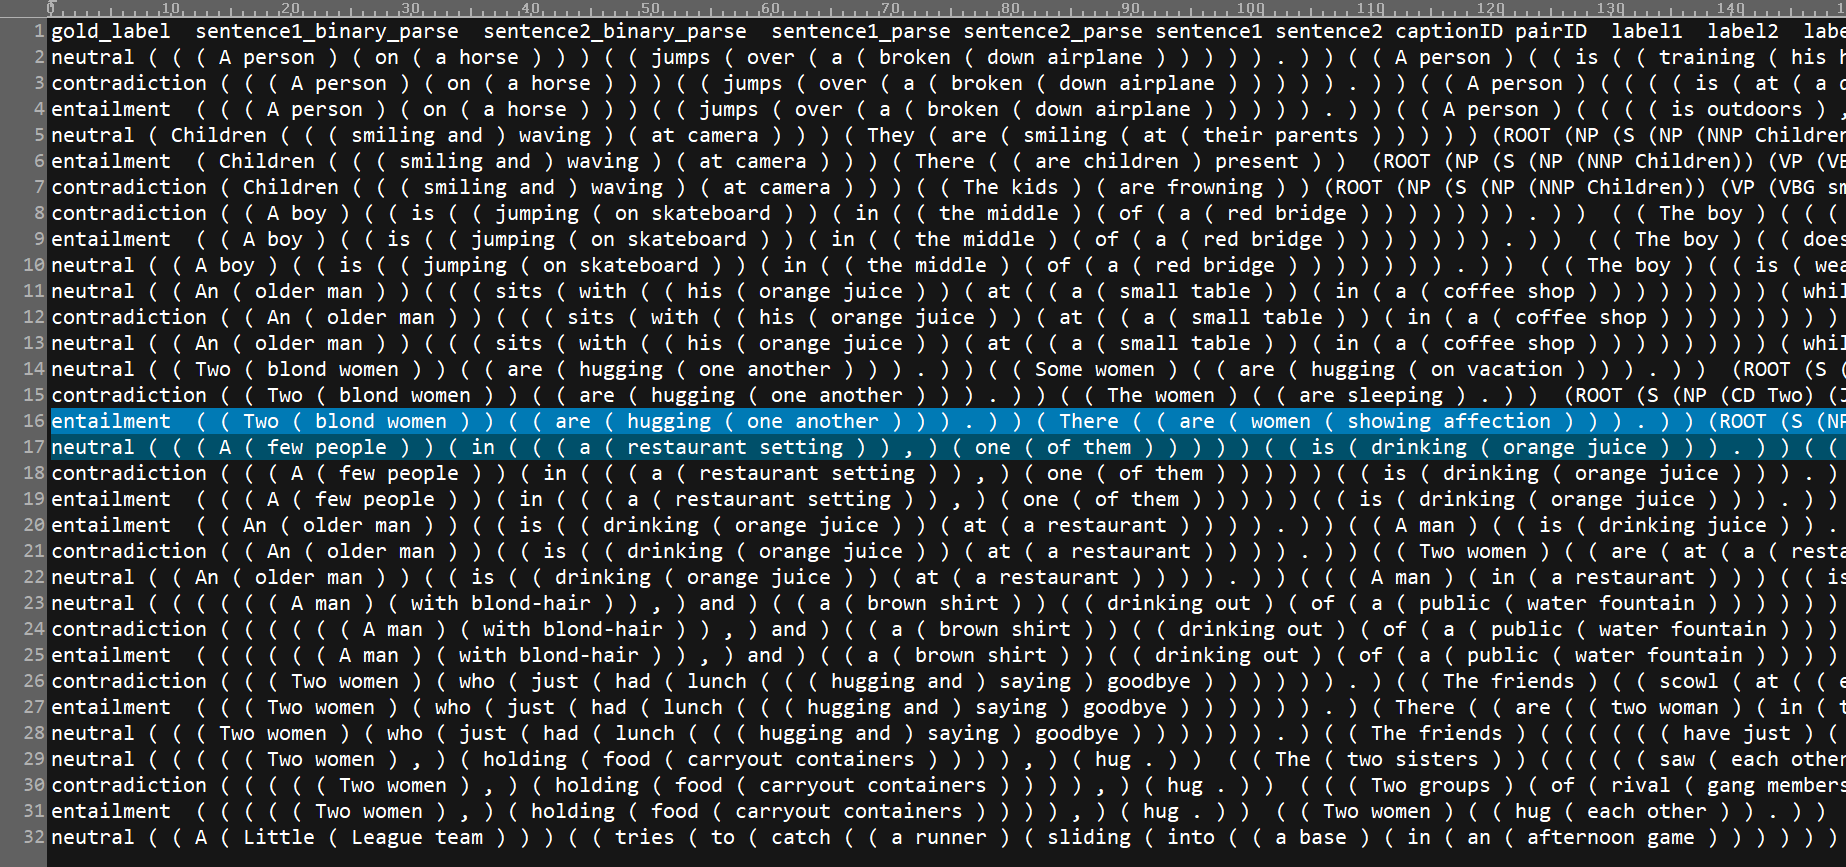

In [32]:
%matplotlib inline
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

##data_dir = d2l.download_extract('SNLI')
data_dir = r'../data/snli_1.0'

### 15.4.2.1 读取数据集
- 原始的SNLI数据集包含的信息比我们在实验中真正需要的信息丰富得多。
- 因此此处定义函数`read_snli`以仅提取数据集的一部分，然后返回前提、假设及其标签的列表。

In [33]:
#@save
def read_snli(data_dir, is_train):
    """将SNLI数据集解析为前提、假设和标签"""
    def extract_text(s):
        # 删除我们不会使用的信息
        ## 去掉左右圆括号
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # 用一个空格替换两个或多个连续的空格
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    ## 将标签从文本字符串转换成0,1,2，分别代表‘蕴含、矛盾、中性’
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    '''
    取出每一行语料，然后在通过'\t'分割每一行,
    最终形成一个二维数组，第一维存储每一行,
    第二维存储每一行的各元素，包括：标签、前提句子、假设句子等.
    '''
    with open(file_name, 'r') as f:
        ## [1:]表示从第二行开始读起，因为第一行是标题
        rows = [row.split('\t') for row in f.readlines()[1:]]
    
    ## 取出前提和假设句子对
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] \
                in label_set]
    ## 取出并转换标签
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

-----------------
- **说明：read_snli函数分解**

In [34]:
## 首先是分割语料的一行
row='neutral	( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) )	( ( A person ) ( ( is ( ( training ( his horse ) ) ( for ( a competition ) ) ) ) . ) )	(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .)))	(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))	A person on a horse jumps over a broken down airplane.	A person is training his horse for a competition.	3416050480.jpg#4	3416050480.jpg#4r1n	neutral				'
## 根据制表符分割字符串
row=row.split('\t')
row

['neutral',
 '( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) )',
 '( ( A person ) ( ( is ( ( training ( his horse ) ) ( for ( a competition ) ) ) ) . ) )',
 '(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .)))',
 '(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))',
 'A person on a horse jumps over a broken down airplane.',
 'A person is training his horse for a competition.',
 '3416050480.jpg#4',
 '3416050480.jpg#4r1n',
 'neutral',
 '',
 '',
 '',
 '']

In [35]:
## 获取前提，注意前提在rows的第2个元素
## 第一个元素是标签
s=row[1]
s = re.sub('\\(', '', s)
s = re.sub('\\)', '', s)
s = re.sub('\\s{2,}', ' ', s)
print(s.strip())

A person on a horse jumps over a broken down airplane .


In [36]:
## 获取假设，其实将双斜杠改成单斜杠，效果一致
s=row[2]
s = re.sub('\(', '', s)
s = re.sub('\)', '', s)
s = re.sub('\s{2,}', ' ', s)
print(s.strip())

A person is training his horse for a competition .


---------

- 打印前3对前提和假设，以及它们的标签
  - 标签：“0”、“1”和“2”分别对应于“蕴涵”、“矛盾”和“中性”。


In [37]:
## read_snli函数返回一个元组，三个元素别为：前提、假设和标签
## 都是以list的形式保存
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('前提：', x0)
    print('假设：', x1)
    print('标签：', y)

前提： A person on a horse jumps over a broken down airplane .
假设： A person is training his horse for a competition .
标签： 2
前提： A person on a horse jumps over a broken down airplane .
假设： A person is at a diner , ordering an omelette .
标签： 1
前提： A person on a horse jumps over a broken down airplane .
假设： A person is outdoors , on a horse .
标签： 0


In [38]:
len(train_data[0]) ##约55万条训练数据

549367

- 训练集约有550000对，测试集约有10000对。
- 下面显示了训练集和测试集中的三个**标签“蕴涵”、“矛盾”和“中性”是平衡的**。


In [39]:
## 测试数据，三个标签的数据数量大致差不多，都是3000多条
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


### 15.4.2.2 定义用于加载数据集的类
- 下面我们来定义一个用于加载SNLI数据集的类。
- 类构造函数中的变量`num_steps`指定文本序列的长度，使得每个小批量序列将具有相同的形状。
- 换句话说，在较长序列中的前`num_steps`个词元之后的标记被截断，而特殊词元“&lt;pad&gt;”将被附加到较短的序列后，直到它们的长度变为`num_steps`。
- 通过实现`__getitem__`功能，我们可以任意访问带有索引`idx`的前提、假设和标签。


In [40]:
#@save
class SNLIDataset(torch.utils.data.Dataset):
    """用于加载SNLI数据集的自定义数据集"""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + \
                all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

### 15.4.2.3 整合代码

- 现在可以调用`read_snli`函数和`SNLIDataset`类来下载SNLI数据集，并返回训练集和测试集的`DataLoader`实例，以及训练集的词表。
- 值得注意的是，此处必须使用从训练集构造的词表作为测试集的词表。
- 因此，在训练集中训练的模型将不知道来自测试集的任何新词元。


In [41]:
#@save
def load_data_snli(batch_size, num_steps=50):
    """下载SNLI数据集并返回数据迭代器和词表"""
    #num_workers = d2l.get_dataloader_workers()
    ## 在windows平台上运行，最好将num_workers设为0
    num_workers=0
    #data_dir = d2l.download_extract('SNLI')
    data_dir = r'../data/snli_1.0'
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

- 在这里将批量大小设置为128时，将序列长度设置为50，并调用`load_data_snli`函数来获取数据迭代器和词表。
- 然后打印词表大小。


In [42]:
#训练文本对条数，测试文本对条数以及词表大小
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

- 现在打印第一个小批量的形状。
- 与情感分析相反，此处有分别代表前提和假设的两个输入`X[0]`和`X[1]`。


In [43]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


## 小结

* 自然语言推断研究“假设”是否可以从“前提”推断出来，其中两者都是文本序列。
* 在自然语言推断中，前提和假设之间的关系包括蕴涵关系、矛盾关系和中性关系。
* 斯坦福自然语言推断（SNLI）语料库是一个比较流行的自然语言推断基准数据集。